## T5 fine-tuning

In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO:transformers.file_utils:PyTorch version 1.7.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.4.0 available.


In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Model

In [5]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [6]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.

Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

In [7]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

## Emotion classification

In [10]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "irritated": 0,
  "disappointed": 1,
  "neutral": 2,
  "happy": 3,
  "delighted": 4
}

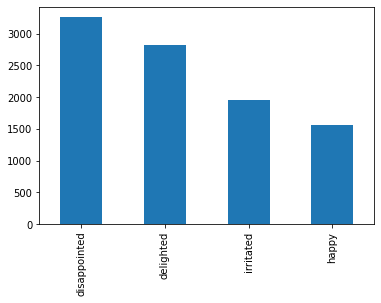

In [11]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="c")
data.emotion.value_counts().plot.bar()

In [12]:
data.head()

,text,emotion
0,neutral didnt feel humiliated,disappointed
1,i can go from feeling so hopeless to so damned...,disappointed
2,im grabbing a minute to post i feel greedy wrong,disappointed
3,i am ever feeling nostalgic about the fireplac...,delighted
4,i am feeling grouchy,disappointed


In [13]:
data.count()

text       9603
emotion    9602
dtype: int64

In [14]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


### Dataset

Here also we will process the examples in the same way we did above. If the label is 'love' we will ask the model to predict the text 'love'

Lets check how t5 encodes the following labels

In [15]:
emotions = [ "irritated", "disappointed", "neutral", "happy", "delighted"]
for em in emotions:
  print(len(tokenizer.encode(em)))

4
1
1
1
1


Here also all the labels are encoded as single ids

In [16]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [17]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
len(dataset)

1004

In [18]:
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i had previously tried to get the broken distance comb through a store, and they wanted to help, but because of illness and only borrowed staff, i could not get answers to what happened in the case for a very long time. when i finally contacted you directly, i was just so happy that we finally managed to get a new distance cam.
delighted


### Train

As I said above there's no need to change the model or add task specific head or any other hyperparameters, we'll just change the dataset and that's it!

In [19]:
!mkdir -p t5_emotion

In [20]:
args_dict.update({'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [21]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [22]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [23]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

In [24]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [25]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.8511, device='cuda:0')

INFO:__main__:loss = tensor(0.2126, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2126, device='cuda:0')

INFO:__main__:val_loss = tensor(0.8511, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.6341, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.8803, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.0775, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0775, device='cuda:0')

INFO:__main__:val_loss = tensor(0.8803, device='cuda:0')



1

### Eval

In [40]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [41]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [42]:
it = iter(loader)

In [43]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [44]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [46]:
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: with a guarantee expired less than a week, the consumer could meet

Actual sentiment: neutral
predicted sentiment: disappointed

text: my problem is solved quickly and easily.

Actual sentiment: delighted
predicted sentiment: delighted

text: fast chat contact, exact information received

Actual sentiment: happy
predicted sentiment: delighted

text: nothing

Actual sentiment: delighted
predicted sentiment: 

text: the desired spare parts in austria or at least in vienna make orderable and collectable!
ordering spare parts abroad, where after 2 days and 2 phone calls my written request is still
answered, is extremely customer-unfriendly! in addition, my philips device is not usable, which is
more than unpleasant...

Actual sentiment: disappointed
predicted sentiment: disappointed

text: it was fine.

Actual sentiment: happy
predicted sentiment: delighted

text: the lady on the phone was very nice and very competent and has solved my concerns quickly.

Actual sentiment: delighted
p

#### Test Metrics

In [32]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [33]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')

50 detected invalid prediction
51 detected invalid prediction
54 detected invalid prediction
65 detected invalid prediction
83 detected invalid prediction
87 detected invalid prediction
96 detected invalid prediction
108 detected invalid prediction
110 detected invalid prediction
119 detected invalid prediction
129 detected invalid prediction
130 detected invalid prediction
162 detected invalid prediction
179 detected invalid prediction
213 detected invalid prediction
222 detected invalid prediction
249 detected invalid prediction
264 detected invalid prediction
281 detected invalid prediction
286 detected invalid prediction
296 detected invalid prediction
299 detected invalid prediction
301 detected invalid prediction
344 detected invalid prediction
346 detected invalid prediction
365 detected invalid prediction
377 detected invalid prediction
386 detected invalid prediction
398 detected invalid prediction
400 detected invalid prediction
428 detected invalid prediction
438 detected in

In [35]:
metrics.accuracy_score(targets, outputs)

0.923